In [3]:
# !pip install opencv-python
# !pip install tqdm
# !pip install torch torchvision torchaudio
# !pip install numpy pandas matplotlib
# !pip install pillow

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
# Ignore DtypeWarnings for the entire notebook
import warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=NameError)

# Data Preparation

## Data Selection

Flower species classification using the "Flowers Recognition" dataset. The dataset contains "daisy", "dandelion", "rose", "sunflower", and "tulip". with each class containing roughly 800 images

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# !ls "/content/drive/My Drive/data"

In [8]:
# ResNet-50 model expects the 224 x 224 pixel images
IMAGE_SIZE = 224

In [9]:
import os
import cv2
import pandas as pd

def make_train_data(data_folder):
    images = []
    labels = []

    for folder_name in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder_name)

        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)

                try:
                    img = cv2.imread(image_path)
                    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE),)
                    if img is not None:
                        images.append(np.array(img))
                        labels.append(str(folder_name))
                except Exception as e:
                    print(f'Error reading image: {image_path}, Error: {e}')
                    
    return np.array(images), labels

# From the flower-input directory the flowers folder names will be the type of flower
images, labels = make_train_data('../data/flowers-input')
# df_raw.head()

In [10]:
images.shape

(4317, 224, 224, 3)

In [11]:
type(images[0])

numpy.ndarray

In [12]:
len(images[0][0][0])

3

In [13]:
# Creating a dataframe
sample_images = images
sample_labels =  labels

# Flatten the 4D array to 2D
flattened_images = sample_images.reshape(len(sample_images), -1)

# Create a DataFrame
df = pd.DataFrame(flattened_images, columns=[f"pixel_{i}" for i in range(flattened_images.shape[1])])
df["labels"] = labels

# Now 'df' contains your data in a DataFrame format
df.head()

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0      134      135      135      139      140      140      145      145   
1      223      216      212      219      213      207      218      211   
2      119      131      136      116      129      132      114      128   
3       81       16       26       79       16       26       79       16   
4       31       49       31       31       43       29       27       31   

   pixel_8  pixel_9  ...  pixel_150519  pixel_150520  pixel_150521  \
0      145      146  ...           127           128           132   
1      209      227  ...           153           168           176   
2      127      109  ...            86            25            53   
3       26       79  ...            48            13            25   
4       23       29  ...            28            33            31   

   pixel_150522  pixel_150523  pixel_150524  pixel_150525  pixel_150526  \
0           127           128           132           127           128   
1           161           170           184           155           158   
2            82            20            48            84            21   
3            49            13            28            47            14   
4            31            39            32            28            38   

   pixel_150527  labels  
0           132   daisy  
1           172   daisy  
2            48   daisy  
3            25   daisy  
4            26   daisy  

[5 rows x 150529 columns]

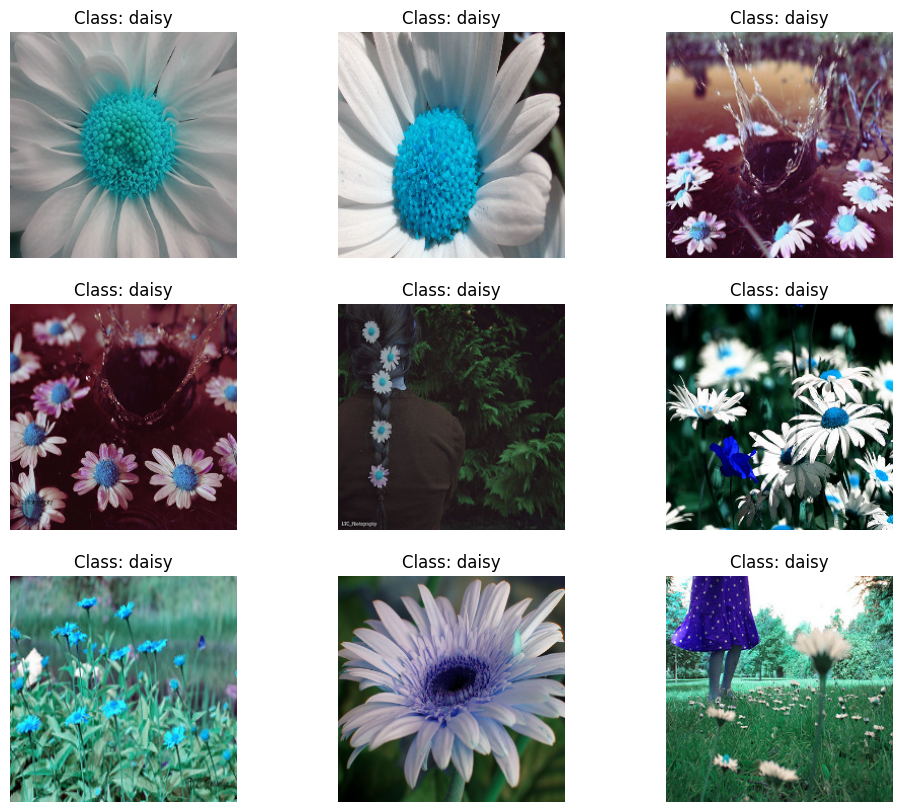

In [14]:
# view the dataset
plt.figure(figsize=(12, 10))

for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow(images[index])
    plt.title(f"Class: {labels[index]}")
    plt.axis("off")

plt.show()

## Data preprocessing

#### Image preprocessing layers
This includes resizing, rescaling and center cropping. However, because we are utilizing a pretrained model the model itself expects the data to be preprocessed in a specific way. The pretrained models provide preprocess_input() function to process the inputs

In [15]:
labels_df = pd.DataFrame(np.array(labels), columns=["Label"])

In [16]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y = le.fit_transform(labels_df)
Y = tf.keras.utils.to_categorical(Y, 5)
Y_encoded_out = pd.DataFrame(data=Y, columns=le.classes_)
Y_encoded_out["Label"] = labels_df

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
num_classes = len(le.classes_[0])
n_classes = le.classes_
print("Classes", n_classes)
print("num of classes", num_classes)

Classes ['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']
num of classes 5


In [18]:
df[Y_encoded_out.columns] = Y_encoded_out

In [19]:
df.head(3)

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0      134      135      135      139      140      140      145      145   
1      223      216      212      219      213      207      218      211   
2      119      131      136      116      129      132      114      128   

   pixel_8  pixel_9  ...  pixel_150525  pixel_150526  pixel_150527  labels  \
0      145      146  ...           127           128           132   daisy   
1      209      227  ...           155           158           172   daisy   
2      127      109  ...            84            21            48   daisy   

   daisy  dandelion  rose  sunflower  tulip  Label  
0    1.0        0.0   0.0        0.0    0.0  daisy  
1    1.0        0.0   0.0        0.0    0.0  daisy  
2    1.0        0.0   0.0        0.0    0.0  daisy  

[3 rows x 150535 columns]

##### Data splitting

In [20]:
Y_encoded_out.shape

(4317, 6)

In [21]:
images.shape

(4317, 224, 224, 3)

In [22]:
from sklearn.model_selection import train_test_split

train_set_X, temp_set_X, train_set_y, temp_set_y = train_test_split(images, Y_encoded_out, test_size=0.25, random_state=42)
valid_set_X, test_set_X, valid_set_y,  test_set_y = train_test_split(temp_set_X, temp_set_y, test_size=0.4, random_state=42)

In [23]:
print("train_set_X set shape", train_set_X.shape)
print("train_set_y set shape", train_set_y.shape)
print("valid_set_X set shape", valid_set_X.shape)
print("valid_set_y set shape", valid_set_y.shape)
print("test_set_X set shape", test_set_X.shape)
print("test_set_y set shape", test_set_y.shape)

train_set_X set shape (3237, 224, 224, 3)
train_set_y set shape (3237, 6)
valid_set_X set shape (648, 224, 224, 3)
valid_set_y set shape (648, 6)
test_set_X set shape (432, 224, 224, 3)
test_set_y set shape (432, 6)


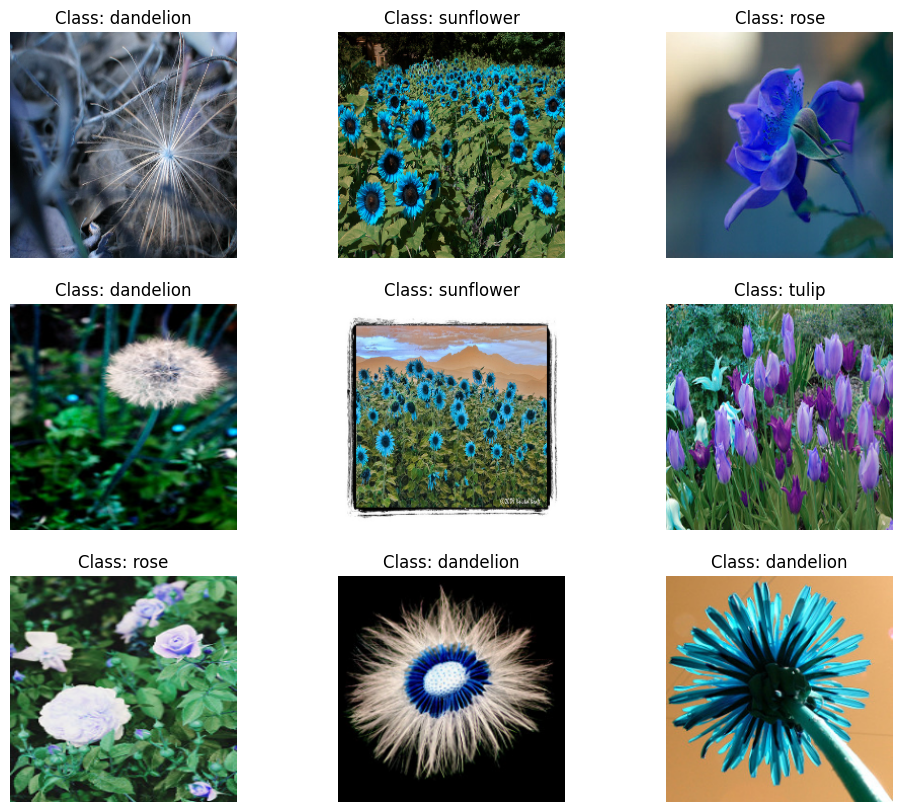

In [24]:
# view the dataset after splitting
plt.figure(figsize=(12, 10))

for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow(train_set_X[index])
    plt.title(f"Class: {train_set_y["Label"].iloc[index]}")
    plt.axis("off")

plt.show()

In [25]:
# ResNet50 image preprocessing layer
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True), # input size as expected by ResNet50
    tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input)  # apply resnet50 preprocess function
])

In [26]:
train_set_X = preprocess(train_set_X)

valid_set_X = preprocess(valid_set_X)

test_set_X = preprocess(test_set_X)

In [27]:
train_set_X.shape

TensorShape([3237, 224, 224, 3])

In [28]:
train_set_y.shape

(3237, 6)

In [29]:
valid_set_X.shape

TensorShape([648, 224, 224, 3])

In [30]:
valid_set_y.shape

(648, 6)

In [31]:
test_set_X.shape

TensorShape([432, 224, 224, 3])

In [32]:
test_set_y.shape

(432, 6)

In [33]:
# drop the Label column
train_set_y_le = train_set_y.drop(columns=["Label"], axis=1)
valid_set_y_le = valid_set_y.drop(columns=["Label"], axis=1)
test_set_y_le = test_set_y.drop(columns=["Label"], axis=1)

In [40]:
train_set_y_le.head(2)

daisy  dandelion  rose  sunflower  tulip
816     0.0        1.0   0.0        0.0    0.0
3317    0.0        0.0   0.0        1.0    0.0

In [41]:
train_set_y_le.shape

(3237, 5)

The dataset is not images of 224x224px with values ranging from -1 to 1

#### data augmentation
Artificially increase size, flipping, varrying contrst and random rotation of training set i.e., generating realistic variants of each training instance. To reduce overfitting
Using keras data augmentation layers

In [ ]:
# a data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])
X_train_augmented = data_augmentation(train_set_X, training=True)

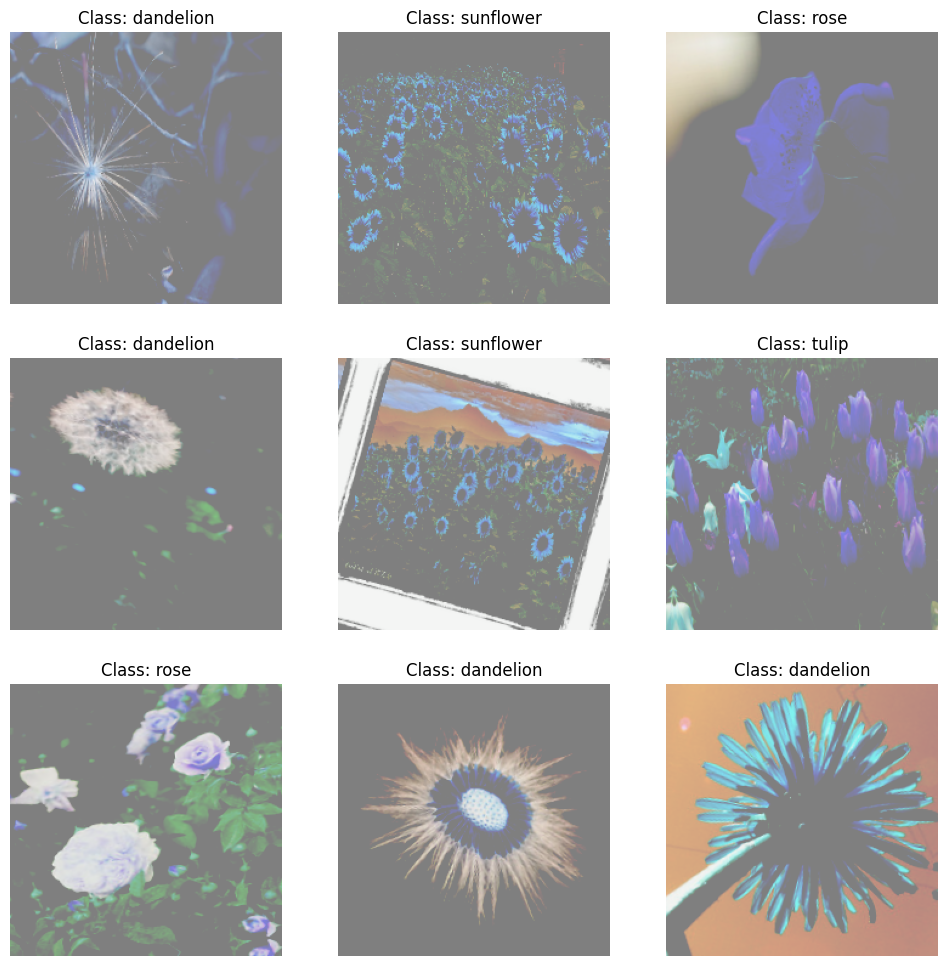

In [ ]:
# view  augmented the dataset
plt.figure(figsize=(12, 12))
for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow(np.clip((X_train_augmented[index] + 1) / 2,0,1))
    plt.title(f"Class: {train_set_y["Label"].iloc[index]}")
    plt.axis("off")

plt.show()

### Loading pretrained ResNet50 from Keras

In [7]:
def build_model():
    base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                        include_top=False)
    #  freeze the weights of pretrained layers
    for layer in base_model.layers:
        layer.trainable = False
    avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    
    # apply activation  drop out regularization technique
    output = tf.keras.layers.Dense(num_classes, 
                                   activation="softmax")(avg)
    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    model.summary()
    return model

In [8]:
build_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add_12[0][0]    

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

<Functional name=functional_1, built=True>

In [57]:
train_set_X.shape

(3237, 224, 224, 3)

In [ ]:
# Build the model layers and train
def build_and_train_model(optimizer, metrics):
    model = build_model()
    
    # loss calculation and metrics
    model.compile(loss="categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    
    # training with 10 epochs using the augmented images
    model.fit(X_train_augmented, train_set_y_le, validation_data=(valid_set_X, valid_set_y_le), epochs=10)
    
    try: 
        model.save("../models/tensor-flow.keras",)
        model = tf.keras.models.load_model("../models/tensor-flow.keras")
    except:
        pass
    return model
    

#### Learning rate scheduling

In [ ]:
# Implementing a learning rate schedule [Exponential schedule]
le_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)

# Also we apply some SGD as optimizers with scheduled lerning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=le_scheduler)

#### Metrics

In [ ]:
model = build_and_train_model(optimizer) 

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 735s 7s/step - accuracy: 0.4817 - loss: 1.3339 - val_accuracy: 0.7284 - val_loss: 0.8381
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 722s 7s/step - accuracy: 0.7419 - loss: 0.8279 - val_accuracy: 0.7639 - val_loss: 0.7016
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 714s 7s/step - accuracy: 0.7684 - loss: 0.7248 - val_accuracy: 0.7886 - val_loss: 0.6293
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 705s 7s/step - accuracy: 0.7911 - loss: 0.6604 - val_accuracy: 0.7948 - val_loss: 0.6012
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 690s 7s/step - accuracy: 0.8147 - loss: 0.6121 - val_accuracy: 0.7978 - val_loss: 0.5885
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 12387s 123s/step - accuracy: 0.7937 - loss: 0.6183 - val_accuracy: 0.8009 - val_loss: 0.5684
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 720s 7s/step - accuracy: 0.8059 - loss: 0.5786 - val_accuracy: 0.8056 - val_loss: 0.5516
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 696s 7s/step - accuracy: 0.8091 - loss: 0.5697 - val_

## Model evaluation and prediction

In [34]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [35]:
def get_predictions(model, dataset=[valid_set_X, valid_set_y_le]):
    val_labels = []  # Store the actual class
    val_predictions = []  # Store the predicted class

    images, labels = dataset
    
    predictions = model.predict(images)  # Get model predictions
    pred_classes = np.argmax(predictions, axis=1)  # 
        
    for index in range(len(images)):  
        # Append the results to the lists
        val_labels.append(labels[index]) 
        val_predictions.append(pred_classes[index])
    
    return val_labels, val_predictions


In [36]:
def get_metrics(val_labels, val_predictions):
    precision = metrics.precision_score(val_labels, val_predictions, average='macro')
    recall = metrics.recall_score(val_labels, val_predictions, average='macro')
    f1_score = metrics.f1_score(val_labels, val_predictions, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")

In [37]:
def get_conf_matrix(val_labels, val_predictions, class_names):
    conf_matrix = metrics.confusion_matrix(val_labels, val_predictions)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
from random import randint
# Function to visualize some sample images with predictions
def visualize_predictions(model, class_names, num_samples=12, data_generator=[test_set_X, test_set_y]):
    
    # destructire the X and Y
    images, labels = data_generator

    # Get model predictions
    predictions = model.predict(images)

    # Get the predicted class indices
    predicted_classes = np.argmax(predictions, axis=1)

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        index = randint(0, len(images))
        plt.subplot(3, 4, i + 1)
        plt.imshow(np.clip((images[index] + 1) / 2,0,1))
        plt.title(
            f"Predicted: {class_names[predicted_classes[index]]}\nTrue class: {labels["Label"].iloc[index]}"
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
model = tf.keras.models.load_model("../models/tensor-flow.keras")

In [ ]:
class_names = n_classes
class_names

array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype=object)

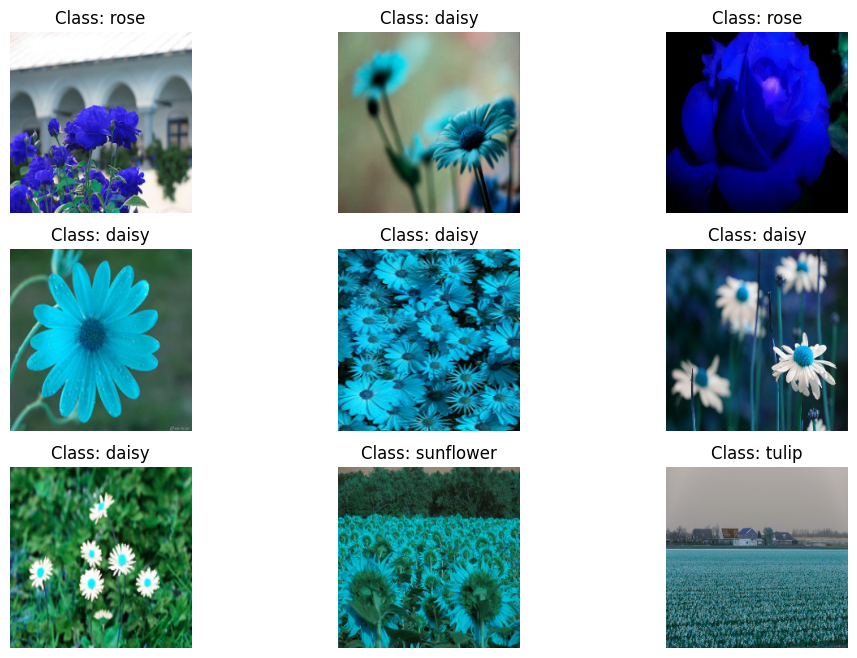

In [45]:
# Viewing the validation set
plt.figure(figsize=(12, 8))

for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow(np.clip((valid_set_X[index] + 1) / 2,0,1))
    plt.title(f"Class: {valid_set_y["Label"].iloc[index]}")
    plt.axis("off")

plt.show()

In [46]:
# encode the y
from sklearn.preprocessing import LabelEncoder

def label_encoder(df):
    label_encoder = LabelEncoder()
    encoded = label_encoder.fit_transform(df)
    classes = label_encoder.classes_
    return encoded, classes


In [47]:
y_test = valid_set_y["Label"]
valid_set_y_le, classes = label_encoder(y_test)
valid_set_y_le[:10], classes

(array([2, 0, 2, 0, 0, 0, 0, 3, 4, 1]),
 array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype=object))

In [48]:
# prediction of validation set
val_labels, val_predictions = get_predictions(model,  dataset=[valid_set_X, valid_set_y_le])

21/21 ━━━━━━━━━━━━━━━━━━━━ 218s 10s/step


In [49]:
# get metrics
get_metrics(val_labels, val_predictions)

Precision: 0.8153
Recall: 0.8132
F1-score: 0.8118


14/14 ━━━━━━━━━━━━━━━━━━━━ 128s 9s/step


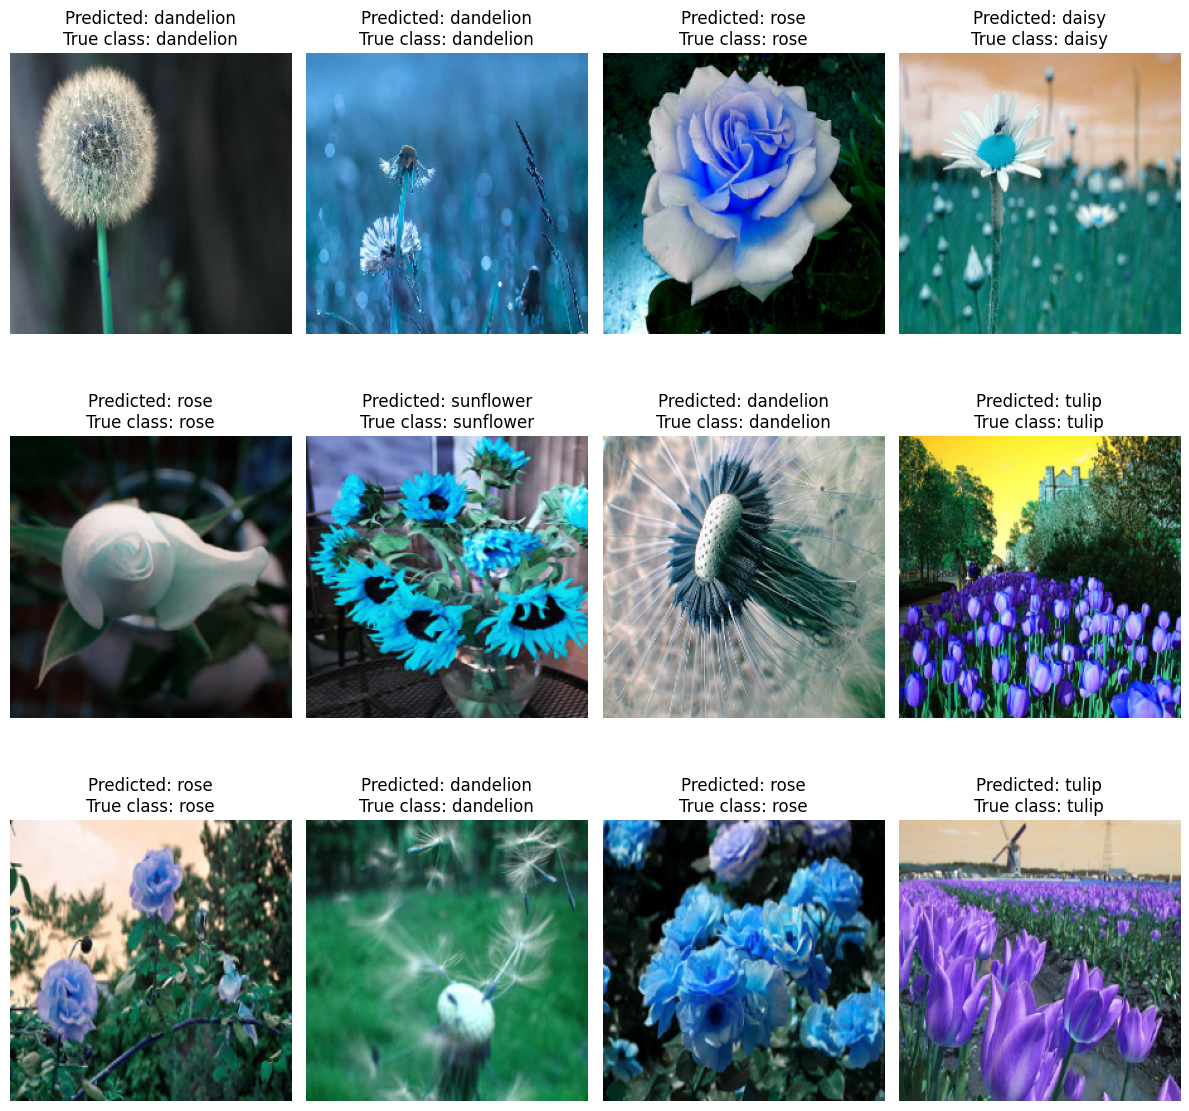

In [50]:
# Visualize predictions
visualize_predictions(model,  class_names)